# System identification for both the stack and cartridges

It was noted that the behaviour of the upper stack of the EVP 3.1 has its cartridges and stack response time that might be too close to achieved separated identification.
This notebook reflects an attempt to tackle this issue.

In [87]:
%matplotlib widget
import matplotlib.pyplot as plt

import re
import numpy as np
import control as ctrl

from utils import lsq, read_pv3_heatdata_txt
from scipy.signal import medfilt, filtfilt, butter, convolve

For the lower stack, the identification worked for 2 second order models:
$$H_{cart} = \frac{b_1^c z + b_0^c}{z^2 + a_1^c z + a_0^c}$$
$$H_{stack} = \frac{b_1 z + b_0}{z^2 + a_1 z + a_0}$$
The sampling time are different for both systems, the cartridges are sampled at 200ms while the stack temperature is sampled at 2s. For a proper analysis, the data needs to be acquired at the highest rate (200ms).

In [88]:
# Reading the data from the PV3 files
file_path = "data/experimental/24_03_25/14_29_39/heatData/"
filename = "Top Heat Controller worker.txt"

data, headers = read_pv3_heatdata_txt(file_path + filename)

t_raw = (data['Time'] - data['Time'][0]) / 1e3 # conversion to seconds 
y_raw = np.array(data['Stack']) # stack temperature

ct_names = ["CT_" + str(i//4+1) + str((i%4) + 1) for i in range(16)]
ct_raw = []
for i in range(16):
    ct_raw.append(data[ct_names[i]])
ct_raw = np.array(ct_raw)

In [89]:
dt = 2e-1 # 200 ms
t = np.arange(np.min(t_raw),np.max(t_raw),dt)
y = np.interp(t,t_raw,y_raw)
ct = np.array([np.interp(t,t_raw,ct_raw_i) for ct_raw_i in ct_raw])

In [90]:
# ploting data
color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(8, 5)) #
ax.set_xlabel('Time [s]')
ax.set_ylabel('Temperature [°C]')
ax.plot(t,y, linewidth=2)
_ = [ax.plot(t,cti, linewidth=0.7) for cti in ct]

In [91]:
# time on 
u = np.zeros(t.shape)
u[(t>121.4) & (t<374.6)] = 200
# add plot
ax_b = ax.twinx()
ax_b.set_ylabel('Time ON [ms]')
ax_b.plot(t, u, color=color_list[1], linestyle='dashed', linewidth=1)

## Splitted identification

To identify the system, the behaviour of the stack can be taken away from the cartridges behaviour, to be able to identify their dynamics properly.

As a first approach, let's substract the stack temperature from the cartridges temperature.

### Cartridge identification

In [92]:
ct_sub = np.array([cti - y for cti in ct])

Text(0.5, 1.0, 'Temperature step response of the upper stack')

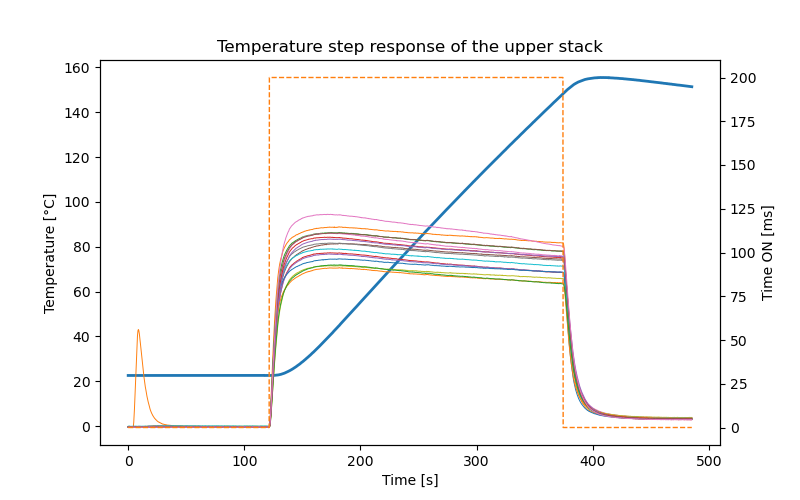

In [93]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(8, 5)) #
ax.set_xlabel('Time [s]')
ax.set_ylabel('Temperature [°C]')
ax.plot(t,y, linewidth=2)
_ = [ax.plot(t,cti, linewidth=0.7) for cti in ct_sub]
# add plot
ax_b = ax.twinx()
ax_b.set_ylabel('Time ON [ms]')
ax_b.plot(t, u, color=color_list[1], linestyle='dashed', linewidth=1)
ax.set_title("Temperature step response of the upper stack")

Text(0.5, 1.0, 'Derivative of temperature variations')

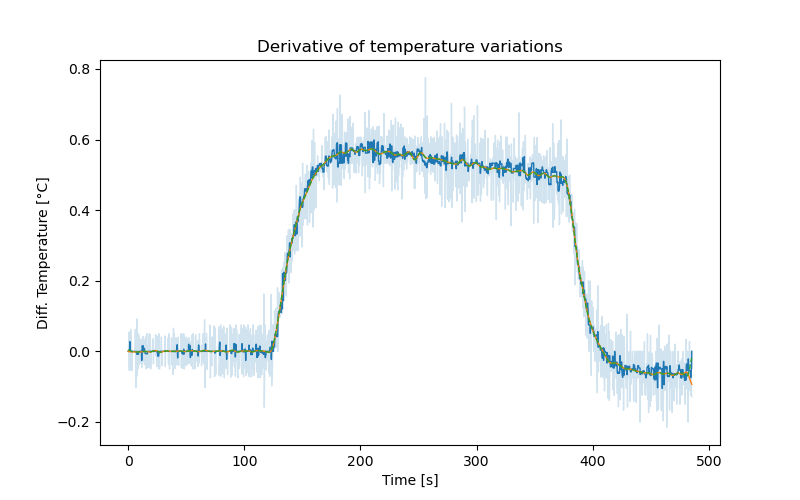

In [94]:
# let's see if a delay is part of the system
# dy = np.diff(y, axis=0)/dt
dy = np.gradient(y, dt, edge_order=2)
dy_medfilt = medfilt(dy, 11) # median filter
b, a = butter(5, 0.005/(0.5*dt), btype='low', analog=False)
dy_butterfilt = filtfilt(b, a, dy)
#
y_filt = filtfilt(b, a, y) # median filter
d_yfilt = np.diff(y_filt, axis=0)/dt

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(8, 5)) #
ax.set_xlabel('Time [s]')
ax.set_ylabel('Diff. Temperature [°C]')
ax.plot(t, dy, color=color_list[0], linewidth=1, alpha=0.2)
ax.plot(t, dy_medfilt, color=color_list[0], linewidth=1)
ax.plot(t, dy_butterfilt, color=color_list[1], linewidth=1)
ax.plot(t[:-1], d_yfilt, color=color_list[2], linewidth=1, linestyle='dashed')
ax.set_title("Derivative of temperature variations")

### Example for a single cartridge

In [95]:
# identification of the cartridges using ARX least square
# y = theta @ [a1,...,an, b1, ..., bn]
cti = 0
na = 2 # input coeff of numerator order + 1
nb = 3 # output coeff of denominator order + 1
idx_0 = np.where(t > 100)[0][0]
t0 = t[idx_0]
u0 = u[idx_0]
ct0 = ct[cti, idx_0]
ct_sub0 = ct_sub[cti, idx_0]
y0 = y[idx_0]
a_coeff, b_coeff, mse = lsq(na, nb, u=u[idx_0:]-u0, y=ct_sub[cti, idx_0:]-ct_sub0, y_init=np.zeros((nb-1,1)))
sysd = ctrl.TransferFunction(a_coeff, np.insert(b_coeff, 0, 1), dt)

sysd

TransferFunction(array([0.00063046, 0.00155008]), array([ 1.        , -1.82288566,  0.82794189]), 0.2)

In [96]:
_, ct_sim = ctrl.forced_response(sysd, t, u-u0)

Text(0.5, 1.0, 'Temperature identification')

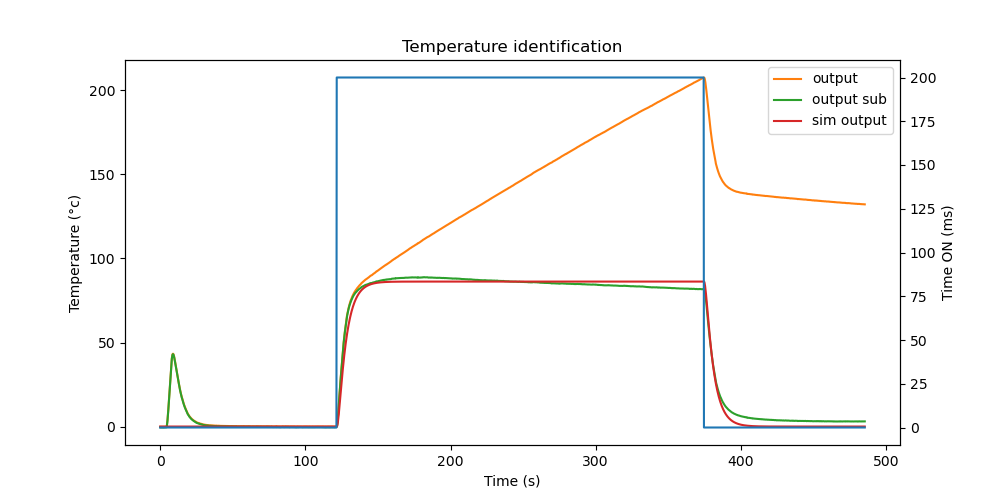

In [97]:
# Plotting the data
_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_xlabel('Time (s)') 
ax.set_ylabel('Temperature (°c)')
ax2 = ax.twinx()
ax2.set_ylabel('Time ON (ms)')

ax2.plot(t, u-u0, color=color_list[0], label='input')
ax.plot(t, ct[cti]-ct0, color=color_list[1], label='output')
ax.plot(t, ct_sub[cti], color=color_list[2], label='output sub')
ax.plot(t, ct_sim, color=color_list[3], label='sim output')

# ax.legend()
ax.legend()
ax.set_title('Temperature identification')

### Generalisation for all cartridges

In [98]:
sys_cart_list = []
mse_list = []
ct_sim = []
for ct_subi in ct_sub: 
    a_coeff, b_coeff, mse = lsq(na, nb, u=u[idx_0:]-u0, y=ct_subi[idx_0:]-ct_subi[idx_0], y_init=np.zeros((nb-1,1)))
    sys_cart_list.append(ctrl.TransferFunction(a_coeff, np.insert(b_coeff, 0, 1), dt))
    mse_list.append(mse)
    _, ct_simi = ctrl.forced_response(sys_cart_list[-1], t, u-u0)
    ct_sim.append(ct_simi)

Text(0.5, 1.0, 'Temperature identification')

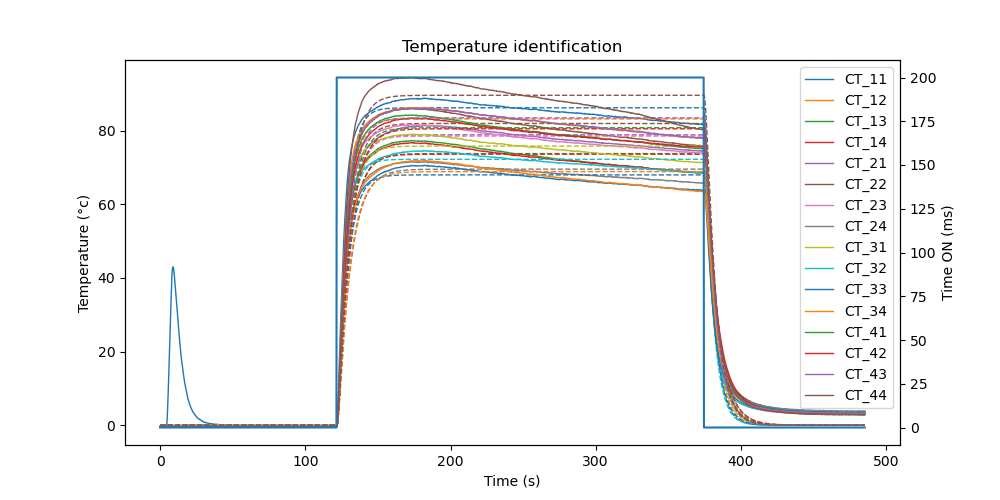

In [99]:
# Plotting the data
_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_xlabel('Time (s)') 
ax.set_ylabel('Temperature (°c)')
ax2 = ax.twinx()
ax2.set_ylabel('Time ON (ms)')

ax2.plot(t, u-u0, color=color_list[0], label='input')
for i, (ct_subi, ct_simi) in enumerate(zip(ct_sub, ct_sim)):
    ax.plot(t, ct_subi, color=color_list[i%10], linewidth=1, label=ct_names[i])
    ax.plot(t, ct_simi, color=color_list[i%10], linestyle="dashed", linewidth=1)

ax.legend()
ax.set_title('Temperature identification')

In [100]:
ct_mean_num = np.mean(np.array([sys_cart.num for sys_cart in sys_cart_list]), axis=0).squeeze()
ct_mean_den = np.mean(np.array([sys_cart.den for sys_cart in sys_cart_list]), axis=0).squeeze()
ct_mean_sys = ctrl.TransferFunction(ct_mean_num, ct_mean_den, dt)
_, ct_mean_sim = ctrl.forced_response(ct_mean_sys, t, u-u0)
ct_mean_sys

TransferFunction(array([0.00023261, 0.0012865 ]), array([ 1.        , -1.83566983,  0.83957486]), 0.2)

In [101]:
ax.plot(t, ct_mean_sim, color='black', linewidth=2, linestyle='dashed', label="mean coeff")
ax.legend()

Text(0.5, 1.0, 'Temperature identification error of the cartridges rapid dynamics')

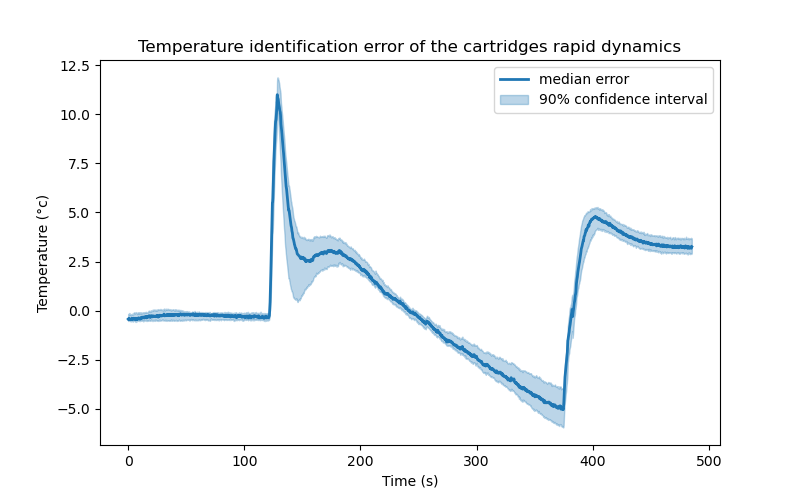

In [102]:
# Plotting the error
_, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.set_xlabel('Time (s)') 
ax.set_ylabel('Temperature (°c)')

# for i, (ct_subi, ct_simi) in enumerate(zip(ct_sub, ct_sim)):
#     ax.plot(t, ct_simi-ct_subi, color=color_list[i%10], linewidth=1, label=ct_names[i])

mean_error = np.mean((ct_sub - ct_sim), axis=0)
median_error = np.median((ct_sub - ct_sim), axis=0)
std_error = np.std((ct_sub - ct_sim), axis=0)
d1_error = np.percentile((ct_sub - ct_sim), 10, axis=0)
d9_error = np.percentile((ct_sub - ct_sim), 90, axis=0)

ax.plot(t, median_error, color=color_list[0], linewidth=2, label="median error")
ax.fill_between(t, d1_error, d9_error, color=color_list[0], alpha=0.3, label='90% confidence interval')

ax.legend()
ax.set_title('Temperature identification error of the cartridges rapid dynamics')

### Stack identification

In [103]:
ct_group_middle = [6,7,10,11]
ct_avg_mid = np.mean(ct[ct_group_middle], axis=0)

In [104]:
idx_id = np.where(u > 0)[0][-1]

In [105]:
_, ax = plt.subplots()
labels = []
ax.set_xlabel('Time (s)')
ax.set_ylabel('Temperature (°c)')
ax.plot(t, y, color=color_list[0], linewidth=2, label='PT100')
ax.plot(t, ct_avg_mid, color=color_list[1], linewidth=2, label='avg. cart.')
ax.legend()
ax.set_title('Upper stack temperature')

Text(0.5, 1.0, 'Upper stack temperature')

In [106]:
# undersampling the data at 0.5Hz
dt_f2 = 2
t_f2 = np.arange(t[0],t[idx_id],dt_f2)
y_f2 = np.interp(t_f2,t,y)
ct_avg_mid_f2 = np.interp(t_f2,t,ct_avg_mid)

In [107]:
na = 2 # input coeff of numerator order + 1
nb = 3 # output coeff of denominator order + 1
a_coeff_stack, b_coeff_stack, mse = lsq(na, nb, u=ct_avg_mid_f2, y=y_f2, y_init=u0*np.ones((nb-1,1)))
sysd_stack = ctrl.TransferFunction(a_coeff_stack, np.insert(b_coeff_stack, 0, 1), dt_f2, name="upper stack model")
ctrl.TransferFunction(sysd_stack, display_format='zpk')

TransferFunction(array([ 0.3911659 , -0.38676126]), array([ 1.        , -1.01582252,  0.01762885]), 2)

In [108]:
_, y_sim = ctrl.forced_response(sysd_stack, t_f2, ct_avg_mid_f2-ct_avg_mid_f2[0])

Text(0.5, 1.0, 'Upper stack temperature')

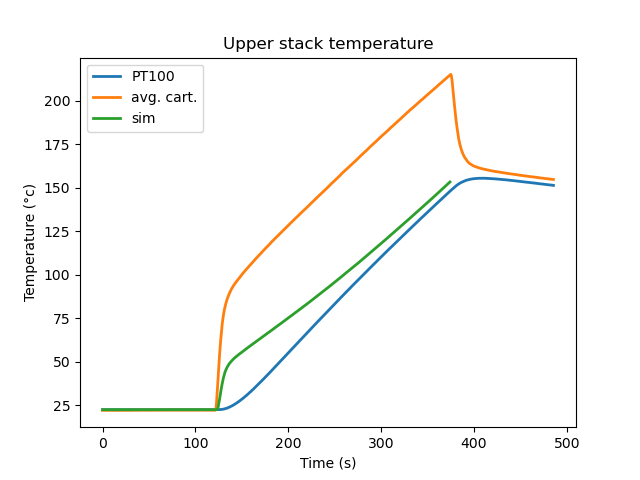

In [109]:
_, ax = plt.subplots()
labels = []
ax.set_xlabel('Time (s)')
ax.set_ylabel('Temperature (°c)')
ax.plot(t, y, color=color_list[0], linewidth=2, label='PT100')
ax.plot(t, ct_avg_mid, color=color_list[1], linewidth=2, label='avg. cart.')
ax.plot(t_f2, y_sim+y_f2[0], color=color_list[2], linewidth=2, label='sim')
ax.legend()
ax.set_title('Upper stack temperature')

The steady state response would greatly improve the identification of the stack. Let's use a previously identification of the upper stack.
$$ \frac{0.003808z + 0.007945}{z^2 - 1.144z + 0.157}, \;  dt=2 $$

In [110]:
b_coeff_old = np.array([0.00380759, 0.00794472])
a_coeff_old = np.array([1., -1.14437971, 0.15697371])
sysd_stack_old = ctrl.TransferFunction(b_coeff_old, a_coeff_old, dt_f2)

In [111]:
_, y_sim_old = ctrl.forced_response(sysd_stack_old, t_f2, ct_avg_mid_f2-ct_avg_mid_f2[0])

In [112]:
ax.plot(t_f2, y_sim_old+y_f2[0], color=color_list[3], linewidth=2, label='sim old')

The identification might not seem great, however, it should be remembered that the trial given here was a first run, which is quite different from the other runs. It is not considered as nominal behaviour.
Another solution for the cartridges identification, might also be to consider an higher order, considering both the cartridges rapid behaviour and it's slower tendencies due to the heating of its suroundings.

## Cartridges identification with higher orders

The cartridges behaviour obvioulsy has higher order dynamics than what was previously assumed. These higher dynamcis were successfully neglected for the lower stack, but it seems that this assumption is insufficient for the upper stack.

In [113]:
# identification of the cartridges using ARX least square
# y = theta @ [a1,...,an, b1, ..., bn]
cti = 0
idx_0 = np.where(t > 100)[0][0]
u0 = u[idx_0]
ct0 = ct[cti, idx_0]
y0 = y[idx_0]
sysd_eval = []
for na in [1,2,3,4]: # input coeff of numerator order + 1
    for nb in [3,4,5]: # output coeff of denominator order + 1
        if na > nb:
            continue
        a_coeff, b_coeff, mse = lsq(na, nb, u=u[idx_0:]-u0, y=ct[cti, idx_0:]-ct0, y_init=np.zeros((nb-1,1)))
        sysd_eval.append({'na': na, 'nb': nb, 'mse': mse, 'sysd': ctrl.TransferFunction(a_coeff, np.insert(b_coeff, 0, 1), dt)})

In [114]:
# plot the results of the identification using 3d plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Input coeff of numerator')
ax.set_ylabel('Output coeff of denominator')
ax.set_zlabel('MSE')
ax.plot_trisurf(np.array([e['na'] for e in sysd_eval]), np.array([e['nb'] for e in sysd_eval]), np.array([e['mse'] for e in sysd_eval]), cmap='viridis')
ax.view_init(30, 120)
ax.set_title('ARX identification MSE')

Text(0.5, 0.92, 'ARX identification MSE')

In [115]:
# simulate the identified models
ct_sim_list = []
for sys in sysd_eval:
    _, tmp_sim = ctrl.forced_response(sys['sysd'], t, u-u0)
    ct_sim_list.append(tmp_sim)

In [116]:
# plot the simulated models
_, ax = plt.subplots()
ax.set_xlabel('Time (s)')
ax.set_ylabel('Temperature (°c)')
ax.plot(t, ct[cti], color=color_list[0], linewidth=2, label='meas.')
for i, sys in enumerate(sysd_eval):
    try:
        ax.plot(t, ct_sim_list[i]+ct0, color=color_list[i+1], linewidth=1, label=f'na:{sys['na']:d},nb:{sys['nb']:d}')
    except:
        ax.plot(t, ct_sim_list[i]+ct0, color=color_list[(i+1)%10+1], linestyle='dashed', linewidth=1, label=f'na:{sys['na']:d},nb:{sys['nb']:d}')
ax.legend()
ax.set_title('Simulated temperature')

Text(0.5, 1.0, 'Simulated temperature')

Trying to identified everything at once does not seem to be the right methodology. Let's reuse the strategy that tries to separate the quick and slow dynamics.

Text(0.5, 1.0, 'Simulated temperature')

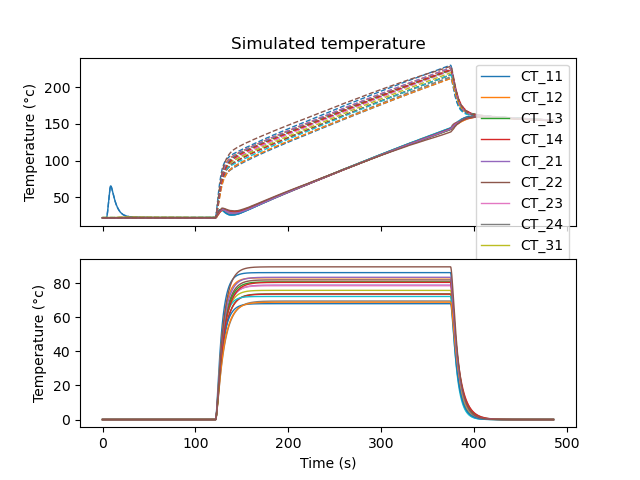

In [117]:
_, ax = plt.subplots(2,1,sharex=True)
ax[1].set_xlabel('Time (s)')
ax[0].set_ylabel('Temperature (°c)')
ax[1].set_ylabel('Temperature (°c)')
for i, ct_simi in enumerate(ct_sim):
    ct_slow = ct[i,:] - ct_simi # substracting the simulated fast dynamics
    # plot
    ax[0].plot(t, ct_slow, color=color_list[i%10], linewidth=1, label=ct_names[i])
    ax[0].plot(t, ct[i,:], color=color_list[i%10], linewidth=1, linestyle='dashed')
    ax[1].plot(t, ct_simi, color=color_list[i%10], linewidth=1, label=ct_names[i])
ax[0].legend()
ax[0].set_title('Simulated temperature')

In [118]:
# identification of the cartridges slow dynamicsusing ARX least square
# y = theta @ [a1,...,an, b1, ..., bn]
na = 1 # b0 / (z + a0)
nb = 2
idx_1 = np.where(t < 375)[0][-1]
u0 = u[idx_0]
sysd_cart_slowd = []
for i, (ct_simi, cti) in enumerate(zip(ct_sim, ct)):
    ct_slowi = cti[idx_0:idx_1] - ct_simi[idx_0:idx_1]
    a_coeff, b_coeff, mse = lsq(na, nb, u=u[idx_0:idx_1]-u0, y=ct_slowi-ct_slowi[0], y_init=np.zeros((nb-1,1)))
    sysd_cart_slowd.append(ctrl.TransferFunction(a_coeff, np.insert(b_coeff, 0, 1), dt))

In [119]:
# simulate the identified models
ct_sim_cmb = []
ct_sys_cmb = []
for i, (sys_slowi, sys_carti) in enumerate(zip(sysd_cart_slowd, sys_cart_list)):
    _, tmp_sim_cmb = ctrl.forced_response(sys_carti+sys_slowi, t, u-u0)
    ct_sys_cmb.append(sys_carti+sys_slowi)
    # _, tmp_sim_qck = ctrl.forced_response(sys_carti, t, u-u0)
    # _, tmp_sim_slw = ctrl.forced_response(sys_slowi, t, u-u0)
    # ct_sim_comb.append({'combined': tmp_sim_cmb, 'quick': tmp_sim_qck, 'slow': tmp_sim_slw})
    ct_sim_cmb.append(tmp_sim_cmb+ct[i,0])

In [120]:
ct_mean_num = np.mean(np.array([sys_cart.num for sys_cart in ct_sys_cmb]), axis=0).squeeze()
ct_mean_den = np.mean(np.array([sys_cart.den for sys_cart in ct_sys_cmb]), axis=0).squeeze()
ct_mean_sys_cmb = ctrl.TransferFunction(ct_mean_num, ct_mean_den, dt)
_, ct_mean_sim_cmb = ctrl.forced_response(ct_mean_sys_cmb, t, u-u0) + np.mean(ct[:,0])

In [121]:
ct_mean_sys_cmb

TransferFunction(array([ 0.00069118,  0.00021201, -0.0009015 ]), array([ 1.        , -2.83573304,  2.67536031, -0.83962753]), 0.2)

Text(0.5, 1.0, 'Simulated temperature')

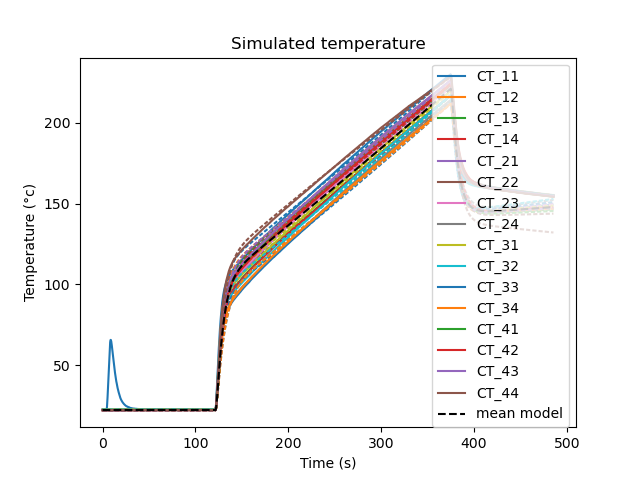

In [122]:
_, ax = plt.subplots(1,1,sharex=True)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Temperature (°c)')
for i, ct_simi in enumerate(ct_sim_cmb):
    ax.plot(t, ct[i,:], color=color_list[i%10], linewidth=1.5, label=ct_names[i])
    ax.plot(t, ct_simi, color=color_list[i%10], linewidth=1.5, linestyle='dashed', dashes=(2, 1))
    # ax.plot(t, ct_simi['combined']+ct[i,0], color=color_list[i%10], linewidth=1.5, linestyle='dashed', dashes=(2, 1))
    # ax.plot(t, ct_simi['quick'], color=color_list[i%10], linewidth=1.5, linestyle='dotted')
    # ax.plot(t, ct_simi['slow'], color=color_list[i%10], linewidth=1.5, linestyle='dashed', dashes=(5, 10))
ax.plot(t, ct_mean_sim_cmb, 'k--', linewidth=1.5, label="mean model")
ax.legend()
ax.set_title('Simulated temperature')

In [123]:
# Plotting the error
_, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.set_xlabel('Time (s)') 
ax.set_ylabel('Temperature (°c)')

error = ct - ct_sim_cmb
mean_error = np.mean(error, axis=0)
median_error = np.median(error, axis=0)
std_error = np.std(error, axis=0)
d1_error = np.percentile(error, 10, axis=0)
d9_error = np.percentile(error, 90, axis=0)

ax.plot(t, median_error, color=color_list[0], linewidth=2, label="median error")
ax.fill_between(t, d1_error, d9_error, color=color_list[0], alpha=0.3, label='90% confidence interval')

ax.legend()
ax.set_title('Temperature identification error, of the cartridges whole dynamics')

Text(0.5, 1.0, 'Temperature identification error, of the cartridges whole dynamics')

The identification of the cartridges with both slow and rapid dynamics brings decent results with non negligeable errors observed during the quick dynamics transient phases.
From the above figure, it can be expected that the cooling behaviour is different from the heating one.

## Identification using pseudo random binary signal (PRBS)

Add a short intro about prbs...

In [124]:
# Reading the data from the PV3 files
file_path = "data/experimental/24_04_09/"
filename = "data_identification.txt"

data, headers = read_pv3_heatdata_txt(file_path + filename)

t_raw = (data['Time'] - data['Time'][0]) / 1e3 # conversion to seconds 
y_raw = np.array(data['Stack']) # stack temperature

ct_names = ["CT_" + str(i//4+1) + str((i%4) + 1) for i in range(16)]
ct_raw = []
for i in range(16):
    ct_raw.append(data[ct_names[i]])
ct_raw = np.array(ct_raw)

ct_cmd_raw = np.array(data['CT_cmd'])

In [125]:
t_prbs = np.arange(np.min(t_raw),np.max(t_raw),dt)
y_prbs = np.interp(t_prbs,t_raw,y_raw)
ct_prbs = np.array([np.interp(t_prbs,t_raw,ct_raw_i) for ct_raw_i in ct_raw])
ct_cmd_prbs = np.interp(t_prbs,t_raw,ct_cmd_raw)

In [126]:
# ploting data
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 5)) #
ax[1].set_xlabel('Time [s]')
ax[0].set_ylabel('Temperature [°C]')
ax[1].set_ylabel('Time ON [ms]')
ax[0].plot(t_prbs,y_prbs, linewidth=2, label='stack')
_ = [ax[0].plot(t_prbs,cti, linewidth=0.7, label=ct_names[i]) for i, cti in enumerate(ct_prbs)]
ax[1].plot(t_prbs,ct_cmd_prbs, linewidth=0.7, label='cmd')
ax[0].legend()

From the previous identifications conducted on step inputs, it seems that each cartridge model can be approached by the sum of the second and a first order model. The result is a model of the following form:
$$H_c(z) = \frac{b_2 z^2 + b_1 z + b_0}{z^3 + a_2 z^2 + a_1 z + a_0}$$
Let's try an identification on this model.

### Identification of all dynamics at once

In [127]:
# identification of the cartridges slow dynamicsusing ARX least square
# y = theta @ [a1,...,an, b1, ..., bn]
na = 3
nb = 4


ct_cmd_prbs[0] = 0
ct_0 = ct_prbs[:,0]
y0 = y_prbs[0]
sysd_cart_prbs = []

for i, cti in enumerate(ct_prbs):
    a_coeff, b_coeff, mse = lsq(na, nb, u=ct_cmd_prbs, y=cti-ct_0[i], y_init=np.zeros((nb-1,1)))
    sysd_cart_prbs.append(ctrl.TransferFunction(a_coeff, np.insert(b_coeff, 0, 1), dt))

In [128]:
sysd_cart_prbs[0]

TransferFunction(array([-0.00050419,  0.00105728,  0.00027999]), array([ 1.        , -1.94069357,  1.07259893, -0.13088625]), 0.2)

In [129]:
# let's compare simulated identified models with the actual data
ct_prbs_sim = []
for i, sys_carti in enumerate(sysd_cart_prbs):
    _, tmp_sim_prbs = ctrl.forced_response(sys_carti, t_prbs, ct_cmd_prbs)
    ct_prbs_sim.append(tmp_sim_prbs)
ct_prbs_sim = np.array(ct_prbs_sim)

In [130]:
# ploting data
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(8, 7)) #
ax[1].set_xlabel('Time [s]')
ax[0].set_ylabel('Temperature [°C]')
ax[1].set_ylabel('Temperature [°C]')
ax[2].set_ylabel('Time ON [ms]')
_ = [ax[0].plot(t_prbs,cti, linewidth=0.7, label=ct_names[i]) for i, cti in enumerate(ct_prbs)]
_ = [ax[1].plot(t_prbs,cti, linewidth=0.7, label=ct_names[i]) for i, cti in enumerate(ct_prbs_sim)]
_ = ax[2].plot(t_prbs, ct_cmd_prbs)
# _ = [ax[2].plot(t_prbs, cti-cti_sim, linewidth=0.7, label=ct_names[i]) for i, (cti, cti_sim) in enumerate(zip(ct_prbs, ct_prbs_sim))]

Once again the identification of every terms at once seems inconclusive.

### Identification separating slow and rapid dynamics

#### Filtering

To separate slow dynamics from the rest, both the input and output signals can be filtered to eliminate rapid dynamics. This is because we know that the time response of each dynamic is approximately separated by a factor of 10.

The sampling frequency is about 200 ms, that is a 5 Hz frequency, with a response time of the cartridges between 5 s and 20 s for its rapid dynamics, and around 400 s for its slow dynamics.

In [147]:
# let's exemplify the filtering with the first cartridge
ct_11 = ct_prbs[0]
# target time window to filter in s
time_wdw = 40 # between the rapid and slow dynamics
# Moving average filtering
window_size = int(time_wdw/dt)
filter = np.ones(window_size) / window_size
ct_11_ma = convolve(ct_11-ct_11[0], filter, mode='same') + ct_11[0]
# Median filtering
ct_11_med = medfilt(ct_11-ct_11[0], window_size+1) + ct_11[0]
# Butterworth lowpass filtering
order = 4
cutoff_freq = 1/time_wdw
b, a = butter(order, cutoff_freq/(0.5/dt), btype='low', analog=False)
ct_11_lp = filtfilt(b, a, ct_11-ct_11[0]) + ct_11[0]

In [151]:
# let's use the same filtering for the input
ct_cmd_ma = convolve(ct_cmd_prbs, filter, mode='same')
ct_cmd_med = medfilt(ct_cmd_prbs, window_size+1)
ct_cmd_lp = filtfilt(b, a, ct_cmd_prbs)

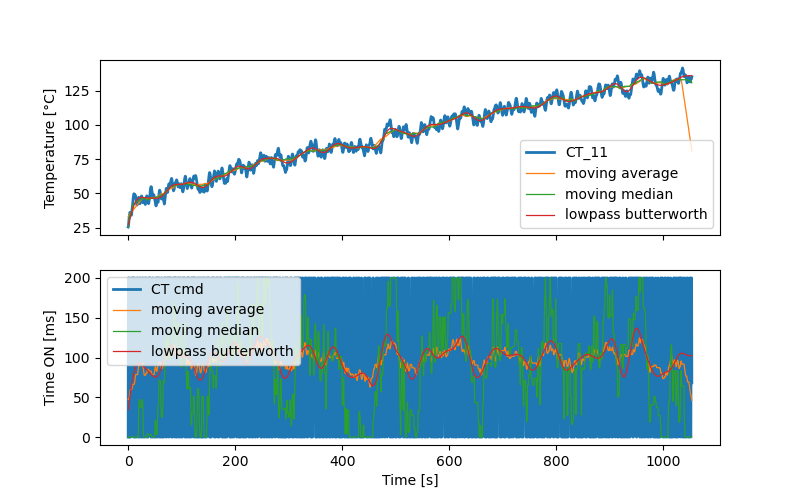

In [152]:
# plot filtering
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 5)) #
ax[1].set_xlabel('Time [s]')
ax[0].set_ylabel('Temperature [°C]')
ax[1].set_ylabel('Time ON [ms]')
ax[0].plot(t_prbs, ct_11, linewidth=2, label='CT_11')
ax[0].plot(t_prbs, ct_11_ma, linewidth=0.9, label='moving average')
ax[0].plot(t_prbs, ct_11_med, linewidth=0.9, label='moving median')
ax[0].plot(t_prbs, ct_11_lp, linewidth=0.9, label='lowpass butterworth')
ax[1].plot(t_prbs, ct_cmd_prbs, linewidth=2, label='CT cmd')
ax[1].plot(t_prbs, ct_cmd_ma, linewidth=0.9, label='moving average')
ax[1].plot(t_prbs, ct_cmd_med, linewidth=0.9, label='moving median')
ax[1].plot(t_prbs, ct_cmd_lp, linewidth=0.9, label='lowpass butterworth')
ax[1].legend()
ax[0].legend()

#### Identification of the filtered signals

Let's try to identify the slow dynamics both using the filtered and raw command signals.

In [168]:
# let's use the low passed filtered signals for the identification
na_slw = 2
nb_slw = 3
ct_cmd_lp[0] = 0 # forcing initial cmd to 0
a_coeff, b_coeff, _ = lsq(na_slw, nb_slw, u=ct_cmd_lp, y=ct_11_lp-ct_11_lp[0], y_init=np.zeros((nb_slw-1,1)))
ct_11_slw_sys = ctrl.TransferFunction(a_coeff, np.insert(b_coeff, 0, 1), dt)
a_coeff, b_coeff, _ = lsq(na_slw-1, nb_slw-1, u=ct_cmd_prbs, y=ct_11_lp-ct_11_lp[0], y_init=np.zeros((nb_slw-2,1)))
ct_11_slw_sys2 = ctrl.TransferFunction(a_coeff, np.insert(b_coeff, 0, 1), dt)
_, ct_11_slw_sim = ctrl.forced_response(ct_11_slw_sys, t_prbs, ct_cmd_lp) + ct_11_lp[0]
_, ct_11_slw_sim2 = ctrl.forced_response(ct_11_slw_sys2, t_prbs, ct_cmd_lp) + ct_11_lp[0]

Text(0.5, 1.0, 'Identification of the CT_11 cartridges slow dynamics')

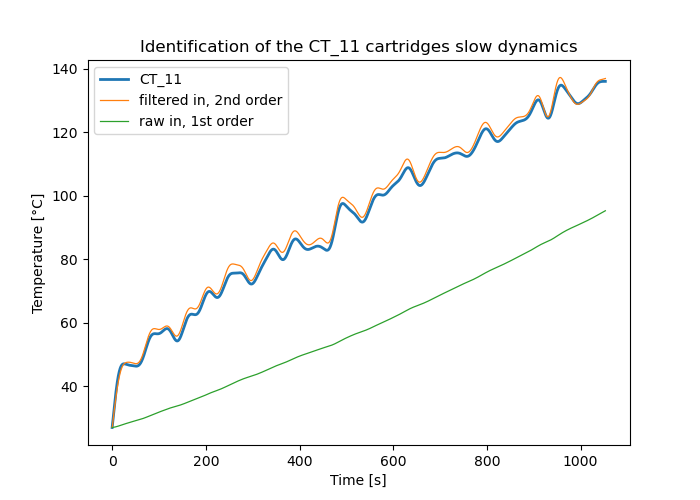

In [173]:
# plot slow dynamics identification
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(7, 5)) #
ax.set_xlabel('Time [s]')
ax.set_ylabel('Temperature [°C]')
ax.plot(t_prbs, ct_11_lp, linewidth=2, label='CT_11')
ax.plot(t_prbs, ct_11_slw_sim, linewidth=0.9, label='filtered in, 2nd order')
ax.plot(t_prbs, ct_11_slw_sim2, linewidth=0.9, label='raw in, 1st order')
ax.legend()
ax.set_title("Identification of the CT_11 cartridges slow dynamics")

It can be seen that the best results were obtained when both the filtered ouput and input were used. 
Moreover, it should be underlined that a first order model was not able to properly explain the model when using the filtered input. The best results were obtained with a second order model with the filtered input.

[*] With the unfiltered data, the best results were obtained with a first order model, but were really far from the ones obtained with filtered input, as it can be seen on the figure above.

In [172]:
ct_11_slw_sys

TransferFunction(array([ 0.00768931, -0.00767951]), array([ 1.        , -1.96222887,  0.96223359]), 0.2)

In [183]:
# let's look at the step response of the identified model
t_step_ct_11_slw, y_step_ct_11_slw = ctrl.step_response(ct_11_slw_sys, T=10000)

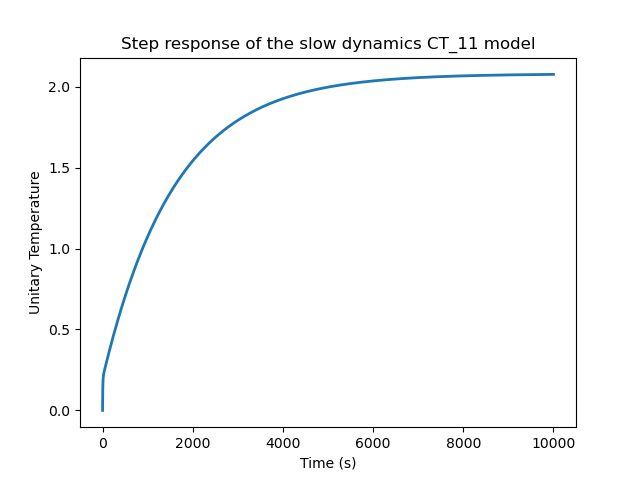

In [188]:
# plot 
_, ax = plt.subplots()
ax.set_xlabel('Time (s)')
ax.set_ylabel('Unitary Temperature')
ax.set_title('Step response of the slow dynamics CT_11 model')
ax.plot(t_step_ct_11_slw, y_step_ct_11_slw, color=color_list[0], linewidth=2, label='CT_11 sim')

Let's have a look at the identified system response when the unfiltered input is fed into the model.

## Analysis

### Frequency analysis

In [133]:
sys_cart_example = ctrl.tf(ct_mean_sys_cmb, name="cartridges mean model")
sys_cart_example

TransferFunction(array([ 0.00069118,  0.00021201, -0.0009015 ]), array([ 1.        , -2.83573304,  2.67536031, -0.83962753]), 0.2)

In [134]:
ctrl.TransferFunction(sys_cart_example, display_format='zpk')

TransferFunction(array([ 0.00069118,  0.00021201, -0.0009015 ]), array([ 1.        , -2.83573304,  2.67536031, -0.83962753]), 0.2)

array([[list([<matplotlib.lines.Line2D object at 0x7f6e05e99370>])],
       [list([<matplotlib.lines.Line2D object at 0x7f6e05d18530>])]],
      dtype=object)

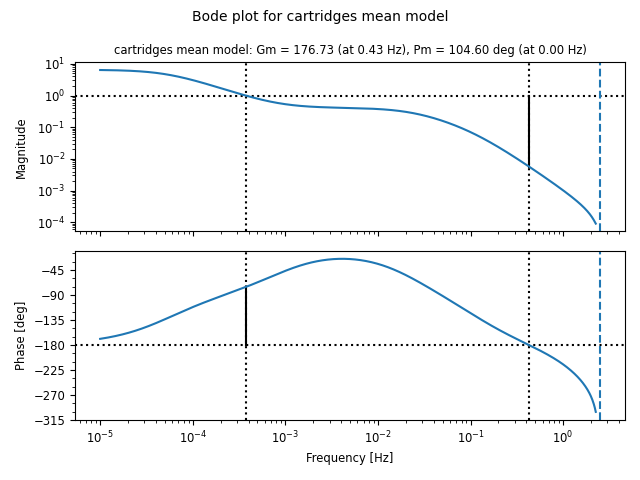

In [135]:
# freq_response = ctrl.frequency_response(ctrl.tf(sysd_cart_slowd[0] + sys_cart_list[0], name="cartridges"))
# _, ax = plt.subplots(1, 1)
ctrl.bode_plot(sys_cart_example, initial_phase=0, display_margins=True, Hz=True)

array([[list([<matplotlib.lines.Line2D object at 0x7f6e0597a990>]),
        list([<matplotlib.lines.Line2D object at 0x7f6e059ffce0>])]],
      dtype=object)

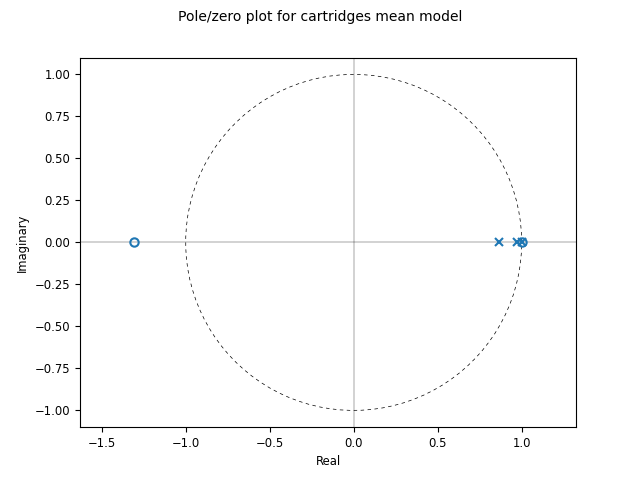

In [136]:
response = ctrl.pole_zero_map(sys_cart_example)
ctrl.pole_zero_plot(response)

### Temporal analysis

In [137]:
t_step_stack_old, y_step_stack_old = ctrl.step_response(sysd_stack_old, T=500)
t_set_5p_stack_old = ctrl.step_info(sysd_stack_old, SettlingTimeThreshold=0.05, T=1000)['SettlingTime']
t_step_cart, y_step_cart = ctrl.step_response(ct_mean_sys, T=500)
t_set_5p_cart = ctrl.step_info(ct_mean_sys, SettlingTimeThreshold=0.05)['SettlingTime']
t_step_cart_cmb, y_step_cart_cmb = ctrl.step_response(ct_mean_sys_cmb, T=500)

In [138]:
t_set_5p_cart

22.200000000000003

In [139]:
# plot 
_, ax = plt.subplots()
ax.set_xlabel('Time (s)')
ax.set_ylabel('Unitary Temperature')

ax.plot(t_step_stack_old, y_step_stack_old, color=color_list[0], linewidth=2, label='stack')
ax.plot(t_step_cart, y_step_cart, color=color_list[1], linewidth=2, label='cart.')
ax.plot(t_step_cart_cmb, y_step_cart_cmb, color=color_list[2], linestyle='dashed', linewidth=2, label='cart. cmb.')
ax.axvline(x=t_set_5p_stack_old, color=color_list[0], linestyle="dashed", linewidth=1)
ax.axvline(x=t_set_5p_cart, color=color_list[1], linestyle="dashed", linewidth=1)
ax.legend()
ax.set_title('Step response comparison')

Text(0.5, 1.0, 'Step response comparison')

**The time constant of each system seems to be sufficiently space for a cascade control.** However, it can be seen that the cartridges model is diverging.

In [140]:
# Simulating the actual behaviour
_, y_sim_cart = ctrl.forced_response(ct_mean_sys_cmb, t, u-u0)
t2 = np.arange(t[0], t[-1], dt_f2)
u_sim_stack = np.interp(t2, t, y_sim_cart)
_, y_sim_stack = ctrl.forced_response(sysd_stack_old, t2, u_sim_stack)

Text(0.5, 1.0, 'Simulated heating response (separately)')

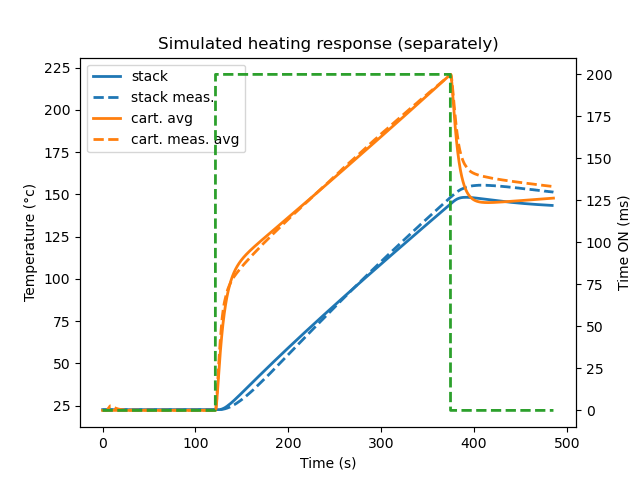

In [141]:
# plot 
_, ax = plt.subplots()
ax.set_xlabel('Time (s)')
ax.set_ylabel('Temperature (°c)')
axb = ax.twinx()
axb.set_ylabel('Time ON (ms)')
axb.plot(t, u, color=color_list[2], linewidth=2, label='input', linestyle='dashed')
ax.plot(t2, y_sim_stack + y[0], color=color_list[0], linewidth=2, label='stack')
ax.plot(t, y, color=color_list[0], linewidth=2, linestyle='dashed', label='stack meas.')
ax.plot(t, y_sim_cart + np.mean(ct[:,0]), color=color_list[1], linewidth=2, label='cart. avg')
ax.plot(t, np.mean(ct, axis=0), color=color_list[1], linewidth=2, linestyle='dashed', label='cart. meas. avg')
ax.legend()
ax.set_title('Simulated heating response (separately)')

In [142]:
# Simulating all the cartridges at the same time using the combined identified system
ct_sim_cart_cmb = []
for cti_sim, cti in zip(ct_sys_cmb, ct):
    _, y_sim_cart = ctrl.forced_response(cti_sim, t, u-u0)
    ct_sim_cart_cmb.append(y_sim_cart)
ct_sim_cart_cmb = np.array(ct_sim_cart_cmb)
# Using the average behaviour of the 4 central cartridges 
mid_cart_idx = [5,6,9,10]
avg_mid = np.mean(ct_sim_cart_cmb[mid_cart_idx], axis=0)
t2 = np.arange(t[0], t[-1], dt_f2)
_, y_sim_stack = ctrl.forced_response(sysd_stack_old, t2, np.interp(t2, t, avg_mid))
err_stack = np.interp(t2, t, y) - y_sim_stack - y[0]

Text(0.5, 1.0, 'Simulated heating response (separately)')

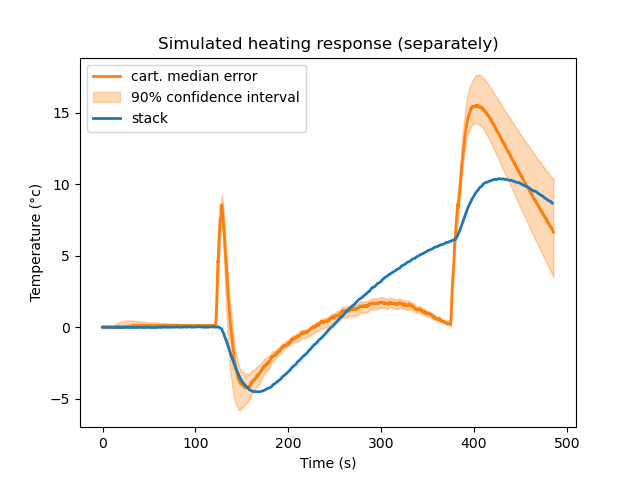

In [143]:
# plot 
_, ax = plt.subplots()
ax.set_xlabel('Time (s)')
ax.set_ylabel('Temperature (°c)')
ax.plot(t, median_error, color=color_list[1], linewidth=2, label="cart. median error")
ax.fill_between(t, d1_error, d9_error, color=color_list[1], alpha=0.3, label='90% confidence interval')
ax.plot(t2, err_stack, color=color_list[0], linewidth=2, label='stack')
ax.legend()
ax.set_title('Simulated heating response (separately)')